Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------  

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import re
import os
import sys
import pathlib
import multiprocessing
import urllib.request
import zipfile
import lxml.etree
import networkx as nx
from random import shuffle

import gensim 
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation, DBSCAN, AgglomerativeClustering, MiniBatchKMeans


%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

In [2]:
import importlib
import logging
importlib.reload(logging)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
#logging.root.setLevel(level=logging.INFO)
#logger = logging.getLogger()
#logger = logging.getLogger(program)
#logger.setLevel(logging.DEBUG)

In [3]:
# https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c
# https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models
# http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/

path_io_files = pathlib.Path('../datasets/Word2Vec/')

In [6]:
pwd

'/dados/home/rsouza/MMD/notebooks'

### Loading Evaluation Tests

In [7]:
questions = '../datasets/Word2vec/questions-words.txt'

In [8]:
evals = open(questions).readlines()
num_sections = len([l for l in evals if l.startswith(':')])
print('total evaluation sentences: {} '.format(len(evals) - num_sections))

total evaluation sentences: 19544 


In [9]:
def w2v_model_accuracy(model):
    accuracy = model.accuracy(questions)
    sum_corr = len(accuracy[-1]['correct'])
    sum_incorr = len(accuracy[-1]['incorrect'])
    total = sum_corr + sum_incorr
    percent = lambda a: a / total * 100
    print('Total sentences: {}, Correct: {:.2f}%, Incorrect: {:.2f}%'.format(total, 
                                                                             percent(sum_corr), 
                                                                             percent(sum_incorr)))

In [10]:
def print_results(model):
    print('queen')
    for result in model.wv.most_similar("queen"):
        print(result)
    print()
    print('man')
    for result in model.wv.most_similar("man"):
        print(result)
    print()
    print('woman')    
    for result in model.wv.most_similar("woman"):
        print(result)
    print()
    print('frog')
    for result in model.wv.most_similar("frog"):
        print(result)
    print()
    print('awful')
    for result in model.wv.most_similar("awful"):
        print(result)
    print()
    print("breakfast cereal dinner lunch:")
    print(model.wv.doesnt_match("breakfast cereal dinner lunch".split()))
    print("captain onion starship alien:")
    print(model.wv.doesnt_match("captain onion starship alien".split()))
    print("father mother son daughter film:")
    print(model.wv.doesnt_match("father mother son daughter film".split()))
    print("france england germany berlin:")
    print(model.wv.doesnt_match("france england germany berlin".split()))
    print("woman", "girl")
    print(model.wv.similarity("woman", "girl"))
    print("woman", "man")
    print(model.wv.similarity("woman", "man"))

### TED Model

In [12]:
#download the data

#url = "https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip"
#urllib.request.urlretrieve(url, filename="ted_en-20160408.zip")

# extract subtitles
with zipfile.ZipFile('../datasets/Word2vec/ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/Word2vec/ted_en-20160408.zip'

In [24]:
# remove parenthesis 
input_text_noparens = re.sub(r'\([^)]*\)', '', input_text)

# store as list of sentences
sentences_strings_ted = []
for line in input_text_noparens.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)
    
# store as list of lists of words
sentences_ted = []
for sent_str in sentences_strings_ted:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

In [25]:
model_ted = Word2Vec(sentences=sentences_ted, size=100, window=5, min_count=5, workers=4, sg=0)

In [46]:
print_results(model_ted)

queen
('jones', 0.7588909864425659)
('princess', 0.7542084455490112)
('president', 0.7531883716583252)
('michael', 0.7283508777618408)
('mary', 0.7250840663909912)
('nurse', 0.712385892868042)
('al', 0.7107840776443481)
('king', 0.7070338129997253)
('bush', 0.7063666582107544)
('tom', 0.7032838463783264)

man
('woman', 0.8365616202354431)
('guy', 0.8240487575531006)
('lady', 0.7715992331504822)
('boy', 0.7510847449302673)
('girl', 0.7498204708099365)
('gentleman', 0.7280703783035278)
('soldier', 0.7220672965049744)
('kid', 0.6989895105361938)
('poet', 0.6664461493492126)
('david', 0.6573689579963684)

woman
('man', 0.8365616202354431)
('girl', 0.816297173500061)
('lady', 0.791056752204895)
('boy', 0.7888074517250061)
('kid', 0.7488728165626526)
('child', 0.7203349471092224)
('soldier', 0.7173367738723755)
('guy', 0.6998787522315979)
('gentleman', 0.6981716156005859)
('nurse', 0.6898905038833618)

frog
('dish', 0.751582145690918)
('chick', 0.7402555346488953)
('shoe', 0.7355747222900391

### Google News Model

In [5]:
googlenews = os.path.join(path_io_files,'GoogleNews-vectors-negative300.bin.gz')

In [6]:
model_googlenews = gensim.models.KeyedVectors.load_word2vec_format(googlenews, binary=True)

In [9]:
w2v_model_accuracy(model_googlenews)

Total sentences: 13190, Correct: 77.08%, Incorrect: 22.92%


In [55]:
print_results(model_googlenews)

queen
('queens', 0.7399442195892334)
('princess', 0.7070531845092773)
('king', 0.6510956883430481)
('monarch', 0.6383601427078247)
('very_pampered_McElhatton', 0.6357026696205139)
('Queen', 0.6163408756256104)
('NYC_anglophiles_aflutter', 0.6060680150985718)
('Queen_Consort', 0.592379629611969)
('princesses', 0.5908075571060181)
('royal', 0.5637185573577881)

man
('woman', 0.7664012312889099)
('boy', 0.6824870109558105)
('teenager', 0.6586930155754089)
('teenage_girl', 0.6147903800010681)
('girl', 0.5921714305877686)
('suspected_purse_snatcher', 0.571636438369751)
('robber', 0.5585119724273682)
('Robbery_suspect', 0.5584409236907959)
('teen_ager', 0.5549196600914001)
('men', 0.5489763021469116)

woman
('man', 0.7664012908935547)
('girl', 0.7494641542434692)
('teenage_girl', 0.7336829900741577)
('teenager', 0.631708562374115)
('lady', 0.6288785934448242)
('teenaged_girl', 0.6141784191131592)
('mother', 0.6076306700706482)
('policewoman', 0.6069462299346924)
('boy', 0.5975908041000366)
(

### Media Cloud Model

In [12]:
#mediacloud = os.path.join(path_io_files, 'MediaCloud_w2v')
mediacloud = os.path.join(path_io_files, 'MediaCloud_w2v_trigrams')

In [13]:
model_mediacloud = gensim.models.Word2Vec.load(mediacloud)

In [14]:
model_mediacloud.most_similar('fgv')

[('fundação_getúlio', 0.7404108047485352),
 ('vargas_fgv', 0.7010539770126343),
 ('fundação_getulio', 0.7001169323921204),
 ('ibre', 0.6558458209037781),
 ('eesp', 0.6423794031143188),
 ('getulio_vargas', 0.6356330513954163),
 ('eaesp', 0.628360390663147),
 ('economia_ibre', 0.625259518623352),
 ('economia_fundação', 0.6108883619308472),
 ('ibre_fgv', 0.6033610701560974)]

In [15]:
def build_neighbors(word, model, nviz=15):
    g = nx.Graph()
    g.add_node(word, {'color':'blue'})
    viz1 = model.most_similar(word, topn=nviz)
    g.add_weighted_edges_from([(word, v, w) for v,w in viz1 if w> 0.5] )
    for v in viz1:
        g.add_weighted_edges_from([(v[0], v2, w2) for v2,w2 in model.most_similar(v[0])])
    return g

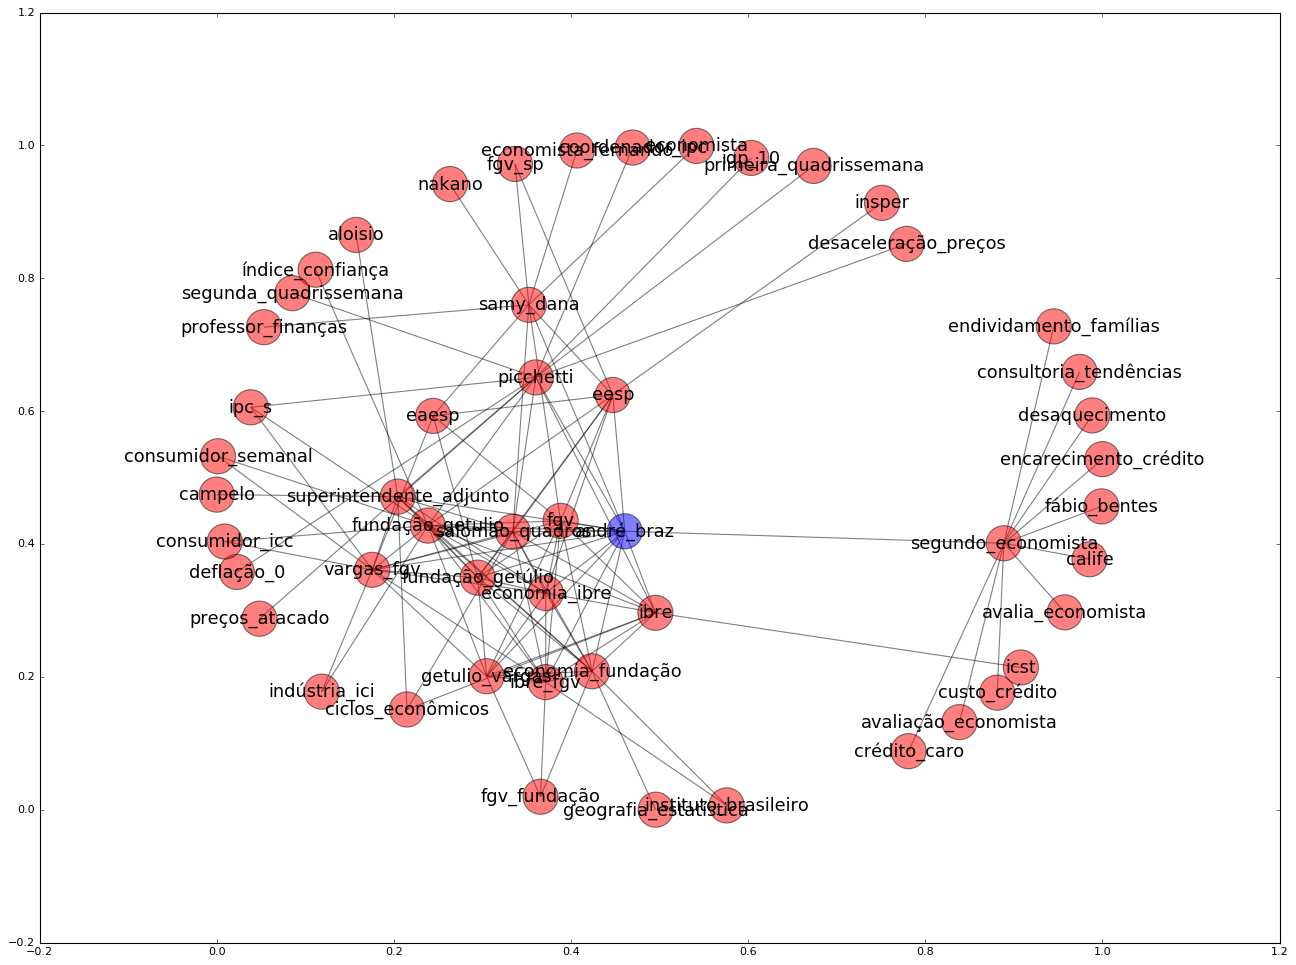

In [16]:
word = 'andré_braz'
g = build_neighbors(word, model_mediacloud)
cols = ['r']*len(g.nodes()); cols[g.nodes().index(word)]='b'
pos = nx.spring_layout(g, iterations=100)
nx.draw_networkx(g,pos=pos, node_color=cols, node_size=1000, alpha=0.5, font_size=16)
#nx.draw_networkx_labels(g, pos,dict(zip(g.nodes(),g.nodes())))

In [56]:
print_results(model_mediacloud)

queen
('banda_britânica', 0.6308628916740417)
('aerosmith', 0.6285808086395264)
('roger_taylor', 0.6270960569381714)
('brian_may', 0.6265591382980347)
('kylie_minogue', 0.6264325380325317)
('foo_fighters', 0.620246410369873)
('ramones', 0.6200276613235474)
('coldplay', 0.6176780462265015)
('damon_albarn', 0.6173127889633179)
('the_smiths', 0.6168573498725891)

man
('runaway', 0.6641627550125122)
('reunion', 0.6501955389976501)
('holidays', 0.6159746646881104)
('colours', 0.6137517690658569)
('eyes', 0.6132105588912964)
('supporter', 0.6131542921066284)
('my_love', 0.6080106496810913)
('wishing', 0.6058506965637207)
('reign', 0.6046998500823975)
('travelling', 0.6033625602722168)

woman
('stabbing', 0.7091230750083923)
('afghan', 0.7054439783096313)
('suicide', 0.7015081644058228)
('firefighters', 0.7010379433631897)
('smoke', 0.6931753754615784)
('explosion', 0.6866195201873779)
('kills', 0.6821645498275757)
('israelis', 0.681576132774353)
('scene', 0.6721864938735962)
('walks', 0.6706

### Wikipedia Model

(You'll need at least 36GB RAM to process this file)  

In [28]:
#http://textminingonline.com/training-word2vec-model-on-english-wikipedia-by-gensim
# Download the raw xml file from wikimedia
# https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2

wikipedia = os.path.join(path_io_files,'enwiki-latest-pages-articles.xml.bz2')

# Use this tool to open the wikimedia dump
wiki = WikiCorpus(wikipedia, lemmatize=False, dictionary={})

In [29]:
# Create a new file and save the processed dump
with open(os.path.join(path_io_files,'wikimedia_processed_w2v'), 'w') as f:
    for text in wiki.get_texts():
        text = [token.decode('utf8') for token in text]
        f.write(' '.join(text) + "\n")

In [30]:
#Create a model based in the processed dump 
with open(os.path.join(path_io_files,'wikimedia_processed_w2v'), 'r') as f:
    model_wikipedia = Word2Vec(LineSentence(f), size=400, window=5, min_count=5, workers=multiprocessing.cpu_count())

In [31]:
# Trim unneeded model memory = use (much) less RAM
model_wikipedia.init_sims(replace=True)
# Save as a model
model_wikipedia.save(os.path.join(path_io_files,'model_wikimedia_w2v'))

In [37]:
# Now you can load only the trimmed model and forget the other files
model_wikipedia = gensim.models.Word2Vec.load(os.path.join(path_io_files,'model_wikimedia_w2v'))

In [38]:
model_wikipedia.wv.vocab["tee"].count

9727

In [41]:
w2v_model_accuracy(model_wikipedia)

Total sentences: 13279, Correct: 77.36%, Incorrect: 22.64%


In [57]:
print_results(model_wikipedia)

queen
('princess', 0.6460756063461304)
('king', 0.6289994120597839)
('empress', 0.5894351601600647)
('monarch', 0.5217301845550537)
('pxqueen', 0.5216491222381592)
('paisieva', 0.5017382502555847)
('maconchy', 0.49410122632980347)
('duchess', 0.4929253160953522)
('modjadji', 0.492704302072525)
('spudvilas', 0.49087032675743103)

man
('woman', 0.6955875754356384)
('boy', 0.6138008832931519)
('girl', 0.6048964262008667)
('person', 0.5231906771659851)
('stranger', 0.5225033760070801)
('drunkard', 0.4907541871070862)
('thug', 0.48446163535118103)
('policeman', 0.47720223665237427)
('swordsman', 0.47702091932296753)
('dog', 0.4716002345085144)

woman
('girl', 0.7082198858261108)
('man', 0.6955875158309937)
('person', 0.6079664826393127)
('prostitute', 0.6071863174438477)
('seductress', 0.5817078351974487)
('divorcee', 0.5421789288520813)
('policewoman', 0.5351531505584717)
('schoolgirl', 0.527353048324585)
('heroine', 0.5256518721580505)
('spinster', 0.515870213508606)

frog
('toad', 0.6976